In [115]:
#Imports
from textblob import TextBlob
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('../data/small_merged_chats')
sw = stopwords.words('english')

# Assign Labels

In [117]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

vad = SentimentIntensityAnalyzer()

In [118]:
df = df.dropna(subset = ['body'])

### Clean up messages first

In [119]:
#Get rid of chats with links (often promo)
def ad(chat):
    return bool(re.search(r'www\.[a-z]?\.?(com)+|[a-z]+\.(com)', chat))

df['is_ad'] = df['body'].apply(ad)

df = df[df['is_ad'] == False]

In [120]:
#change popular emojis to one type so no variants
def emoji_shorten(chat):
    chat = re.sub(r'(?i) \bpog(\w)*\b |\bpog(\w)*\b', '', chat)
    chat = re.sub(r'(?i) \blul(\w)*\b |\blul(\w)*\b', '', chat)
    chat = re.sub(r'(?i) \bkappa(\w)*\b |\bkappa(\w)*\b', '', chat)
    return chat

In [121]:
df['chats'] = df.body.apply(lambda x: emoji_shorten(x))

In [122]:
df = df.drop(['is_ad'], axis = 1)

In [134]:
#Words to add to VADER
# EMOTES: https://dl.acm.org/doi/10.1145/3365523
new_words = {
    'noice': 1.8,
    'scum': -2.0,
    'kap': 0.5,
    'kappa': 0.5,
    'lul': 1.8,
    'omegalol': 1.8,
    'strats': 2.0,
    'rekt': 0,
    'owo': 1.0,
    'tweaker': -2.3,
    'pog': 2.8,
    'pag': 2.8,
    'incel': -3.1,
    'tilted': -0.7,
    'feelsbadman': -2.6,
    'feelsgoodman': 3.7,
    'trash': -2.0,
    'rip': -1.2,
    'ez': 1.9,
    'clap': 2.7,
    'hyperbruh': -0.6,
    'f': 0.5,
    'F': 0.5,
    'discord': 0,
    'PJSalt': -1.2,
    'Kreygasm': 2.8,
    'kreygasm': 2.8,
    'homo': -3.5
}

vad.lexicon.update(new_words)

In [129]:
if 'Kreygasm' in not_in_vocab:
    print('yes')

In [162]:
vad.lexicon['lul']

1.8

In [126]:
tt = TweetTokenizer()
all_words = []
for chat in df['chats']:
    all_words.extend(tt.tokenize(chat))

In [127]:
vocab = set(all_words)
not_in_vocab = []
for word in vocab:
    if word in vad.lexicon:
        continue
    else:
        not_in_vocab.append(word)

In [128]:
len(not_in_vocab)

34559

In [40]:
not_in_vocab

### Assign the labels here

In [130]:
positive = 0
negative = 0
neutral = 0
polarity = 0
neutral_list = []
negative_list = []
positive_list = []
for chat in df.chats:
    analysis = TextBlob(chat)
    score = SentimentIntensityAnalyzer().polarity_scores(chat)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    polarity += analysis.sentiment.polarity
 
    if neg > pos:
        negative_list.append(chat)
        negative += 1
    elif pos > neg:
        positive_list.append(chat)
        positive += 1
 
    elif pos == neg:
        neutral_list.append(chat)
        neutral += 1

In [131]:
print(len(neutral_list))
print(len(negative_list))
print(len(positive_list))

70204
10861
21931


In [132]:
negative_list

['Just picked up a new career high, 16 kill solo squad 🤷🏿\u200d♂️',
 'discord notification gang',
 'yo my flow be fast, and my building be badass',
 'Put in the time dnt be scared to get into fights',
 '@sambro415 don’t just go into games, when you die analyze why your dying then fix what your doing wrong, land in high action places, improve your aim and building.',
 'damn hes streaming rn',
 "@c0nfus3d_tv my mom mad me cancel it so it doesnt charge her so i can't",
 'so when is he going to stop playing?',
 'hey you @phoenixflare42 my sub expires tomorrow :(',
 '@Jessie148 Damn RIP',
 'legit have no money until june 12th which is my birthday @phoenixflare42',
 'No money till December 29',
 'MOIST everyone say it no homo',
 '@phoenixflare42 ikr like i cry cause when its in sub mode i cant chat and its gonna make me cry lmfao',
 'moist no homo',
 'moist no homo',
 '@phoenixflare42 :(',
 'Fuck you cunt ass bitch',
 'Any attack helicopters in the chat?',
 '@phoenixflare42 i dont ask lol, t

# Add labels to dataset

In [135]:
df["label"] = np.where(df["chats"].isin(negative_list), 1, 0)

# Cleaning chats for model

In [136]:
#Functions to tokenize text
from nltk.stem.snowball import SnowballStemmer

#Replaces pos tags with lemmatize compatable tags
def pos_replace(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
#Makes list of punctuation to exclude, keeps certain symbols
punct = list(string.punctuation)
keep_punct = ['?', '!', '@', ',', '.']
punct = [p for p in punct if p not in keep_punct]

#Removes non-ASCII characters (aka emojis that cant be converted to original symbol)
def remove_junk(tweet):
    return ''.join([i if ord(i) < 128 else ' ' for i in tweet])
    
"""
Try handling misspellings?
True reduce_len = True
"""

def chat_tokenizer(doc, stop_words = sw):
    #Any regex needed
    doc = re.sub(r'http\S+', '', doc)
    #Gets rid of weird characters
    doc = remove_junk(doc)
    #Tokenizes using NLTK Twitter Tokenizer as similar to tweets
    chat_token = TweetTokenizer(strip_handles = True)
    doc = chat_token.tokenize(doc)
    #Gets rid of numbers
#     doc_2 = []
#     for w in doc:
#         if any([c.isdigit() for c in w]):
#             pass
#         else:
#             doc_2.append(w)
    #Gets rid of leftover stopwords/punctuation
    #doc = [w for w in doc if w.lower() not in sw]
    doc = [w for w in doc if w not in punct]
    #Stemmer
#     snows = SnowballStemmer('english')
#     doc = [snows.stem(w) for w in doc]
    #Lemmatizes tokens
    doc = pos_tag(doc)
    doc = [(w[0], pos_replace(w[1])) for w in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    
    return doc

# Data Exploration

<ipython-input-137-e30479c4c8b0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_vid['time'] = one_vid['offset'] // 60


<AxesSubplot:xlabel='time'>

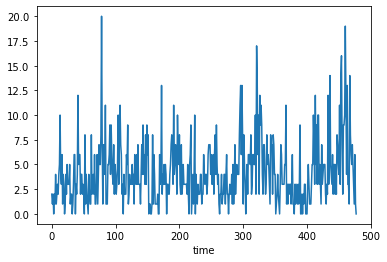

In [137]:
#Graphing hate over course of a single stream
one_vid = df[df['video_id'] == 262866347]
one_vid['time'] = one_vid['offset'] // 60
graph = one_vid.groupby('time')['label'].sum()
graph.plot()

<AxesSubplot:>

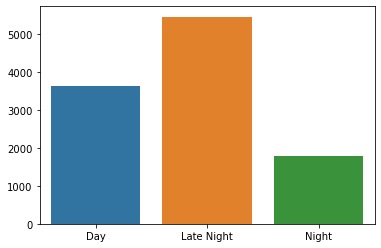

In [149]:
#Most frequent time of day for hate speech
graph = df.groupby('day_night')['label'].sum()
bar_heights = list(graph.values)
index = list(graph.index)

fig, ax = plt.subplots()
sns.barplot(x = index, y = bar_heights)

<AxesSubplot:>

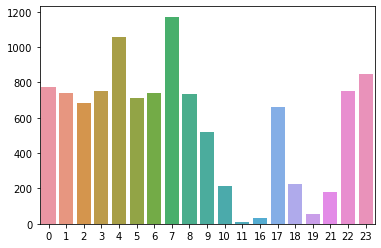

In [150]:
graph = df.groupby('hour')['label'].sum()
bar_heights = list(graph.values)
index = list(graph.index)

fig, ax = plt.subplots()
sns.barplot(x = index, y = bar_heights)

<AxesSubplot:>

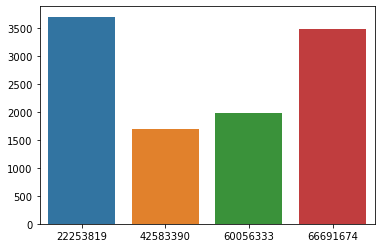

In [151]:
#Hate per streamer
graph = df.groupby('channel_id')['label'].sum()
bar_heights = list(graph.values)
index = list(graph.index)

fig, ax = plt.subplots()
sns.barplot(x = index, y = bar_heights)

<AxesSubplot:>

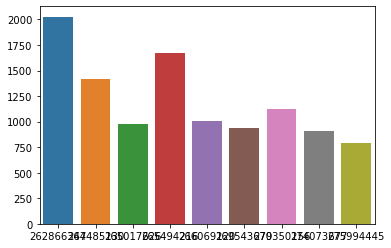

In [152]:
#Hate per stream
graph = df.groupby(['video_id'])['label'].sum()
bar_heights = list(graph.values)
index = list(graph.index)

fig, ax = plt.subplots()
sns.barplot(x = index, y = bar_heights)

<AxesSubplot:>

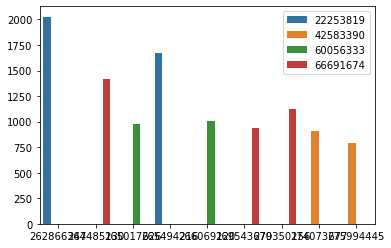

In [153]:
#Hate per stream by creator
graph = df.groupby(['channel_id', 'video_id'])['label'].sum()
video = []
creator = []
for i in graph.index:
    creator.append(i[0])
    video.append(i[1])
height = graph.values

fig, ax = plt.subplots()
sns.barplot(x = video, y = height, hue = creator)

# Feature Engineering

In [148]:
#Hour of stream
df['created_at'] = pd.to_datetime(df['created_at'])
df['hour'] = df.created_at.apply(lambda x: x.hour)

#Sorts streams into night/day
def day_night(hour):
    if (hour >= 7) and (hour < 20):
        return 'Day'
    elif (hour >= 20) and (hour <= 23):
        return 'Night'
    else:
        return 'Late Night'
df['day_night'] = df.hour.apply(day_night)

In [14]:
#Has emojis
def any_emojis(emotes):
    if emotes[2] == 'N':
        return 0
    else:
        return 1

In [15]:
#Convert offset to minutes not seconds
df['stream_min'] = df['offset'] // 60

#Adds if chat contains emojis or not
df['any_emojis'] = df.emotes.apply(any_emojis)

In [154]:
#Length of stream
graph = df.groupby(['video_id'])['offset'].max()
graph

video_id
262866347    28621.659
264485130    29675.843
265017626     8621.629
265494216    28173.764
266069120    11240.598
269543679    17877.104
270350156    16386.012
274073677    19613.873
275994445    19203.889
Name: offset, dtype: float64

# First Simple Model

In [155]:
df.label.value_counts(normalize = True)

0    0.894549
1    0.105451
Name: label, dtype: float64

In [156]:
from sklearn.metrics import recall_score

y = df['label']
X = df['chats']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

first = imbpipeline(steps=[
    ('preproc', CountVectorizer(lowercase = False, tokenizer = chat_tokenizer)),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('dtc', DecisionTreeClassifier(random_state = 213, max_depth = 5))
])

first.fit(X_train, y_train)
preds = first.predict(X_train)
print("Training Score:", recall_score(preds, y_train))
scores = np.mean(cross_val_score(first, X_train, y_train, cv = 5, scoring = 'recall'))
print("Validation Score:" + str(scores))

Training Score: 0.8660194174757282
Validation Score:0.21866820701698195


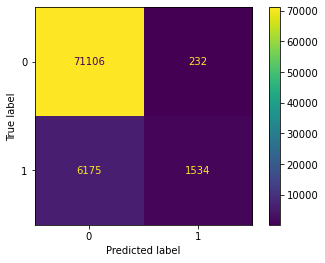

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_hat = first.predict(X_train)
cm = confusion_matrix(y_train, y_hat)
cmdis = ConfusionMatrixDisplay(cm)
cmdis.plot();

# Iterations

In [ ]:
#Creates features and target then performs train test split
y = tweets['label']
X = tweets.drop(['label'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

#Creates preprocessing step
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(lowercase = False, tokenizer = tweet_tokenizer), 'chats')],
    #('ohe', OneHotEncoder(), ['what_product'])],
    remainder = 'passthrough')

#Creates pipeline for model
apple_cv = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('mnb', MultinomialNB())
])

#Fits model and prints training score
apple_cv.fit(X_train, y_train)
print("Training Score:", apple_cv.score(X_train, y_train))
#Cross validates model and prints average result
scores = np.mean(cross_val_score(apple_cv, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))